## Projekt - próba przewidzenia parametru $R_0$ przy użyciu uczenia maszynowego

#### Autorzy: Łukasz Eckert 132218, Damian Horna 132240

### 1. Wprowadzenie

Model SEIRD to tzw. compartmental model wykorzystywany w celu modelowania
rozwoju epidemii. W modelu tym populacja jest podzielona na kilka grup, które opiszemy
poniżej. Skrót SEIRD rozwija się następująco:
* S - Susceptible - liczba osób podatnych na zachorowanie
* E - Exposed - liczba osób, u których choroba jest w stadium inkubacji
* I - Infectious - liczba osób, które rozprzestrzeniają chorobę
* R - Recovered - liczba osób, które wyzdrowiały
* D - Dead - liczba osób, które zmarły

![title](img/seird.png)

Obserwacje w tym modelu przepływają pomiędzy odpowiednimi bloczkami, proces ten można przedstawić za pomocą następujących równań różniczkowych:

![eq](img/equations.png)

Gdzie:
* N - całkowita populacja
* $S(t)$ - liczba osób podatnych (susceptible) do dnia t
* $E(t)$ - lliczba osób, u których choroba jest w stadium inkubacji do dnia t
* $I(t)$ - liczba osób zainfektowanych do dnia t
* $R(t)$ - liczba osób, które wyzdrowiały do dnia t
* $D(t)$ - liczba osób, które zmarły do dnia t
* $\beta$ - ozcekiwana liczba osób, którą zainfekowana osoba zaraża każdego dnia
* $D$ - liczba dni, przez które zainfekowana osoba może zarażać
* $\gamma$ - proporcja zainfekowanych, którzy zdrowieją każdego dnia ($\gamma = 1/D$)
* $R_0$ - łączna liczba osób, którą zainfekowana choroba zaraża ($R_0 = \beta / \gamma$)
* $\delta$ - długość okresu inkubacji
* $\alpha$ - współczynnik śmiertelności
* $\rho$ - tempo umieralności (=1/liczba dni od zainfekowania do śmierci)

## 2. Wygenerowanie sztucznego zbioru danych

### 2.1. Pojedyncza symulacja 

In [7]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

Na początku wygenerujemy proste dane z modelu SEIRD. Model, który opisuje założoną przez nas rzeczywistość mozna opisać poniższymi równaniami różniczkowymi:

In [8]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

Ustawiamy parametry początkowe symulacji:

In [9]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [10]:
t = np.linspace(0, 100, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

Przykładowy przebieg symulowanej epidemii

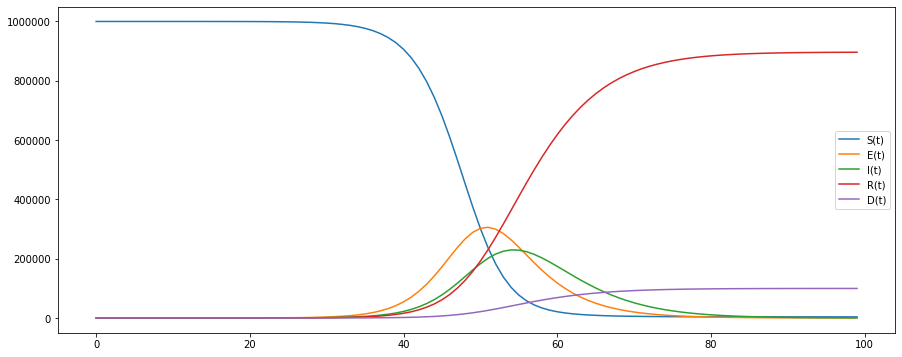

In [15]:
plt.figure(figsize=(15,6))
plt.plot(S, label='S(t)')
plt.plot(E, label='E(t)')
plt.plot(I, label='I(t)')
plt.plot(R, label='R(t)')
plt.plot(D, label='D(t)')
plt.legend()

Wygenerowane dane prezentują symulowany przebieg epidemii w okresie stu dni przy założonych warunkach początkowych i współczynnikach $\alpha, \beta, \gamma, \delta, \rho$

### 2.2. Wygenerowanie całego zbioru

In [16]:
from tqdm import tqdm
N=60e6 # populacja - ustawiamy ją w ten sposób, aby odpowiadała danym z Włoch
D_vals = np.arange(4,10,1) # liczba dni, podczas których zainfekowany zaraża
delta_vals = 1/np.arange(5,15,1) # 1/długość okresu inkubacji w dniach
R_0_vals = np.arange(2,5,0.25) # oczek. liczba osób, które zostaną zarażone przez jednego zainfekowanego
alpha_vals = np.arange(0.02, 0.2, 0.02) # wsp. śmiertelności
rho_vals = 1/np.arange(9,20,1) # tempo umieralności (1 / liczba dni do śmierci)
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

X_train = []
y_train = []

for D in tqdm(D_vals):
    for delta in delta_vals:
        for R_0 in R_0_vals:
            for alpha in alpha_vals:
                for rho in rho_vals:
                    gamma = 1.0/D
                    beta = R_0 * gamma
                    t = np.linspace(0, 46, 46) # Grid of time points (in days)
                    y0 = S0, E0, I0, R0, D0 # Initial conditions vector

                    # Integrate the SIR equations over the time grid, t.
                    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
                    #S, E, I, R, D = ret.T
                    X_train.append(ret.T)
                    y_train.append([beta, gamma, delta, alpha, rho])

100%|██████████| 6/6 [00:53<00:00,  8.86s/it]


In [17]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [18]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)

### 2.3. Podejrzenie przykładów uczących

In [35]:
def plot_train_example(ex):
    plt.figure(figsize=(15,6))
#     plt.plot(ex[0], label='S(t)')
    plt.plot(ex[1], label='E(t)')
    plt.plot(ex[2], label='I(t)')
    plt.plot(ex[3], label='R(t)')
    plt.plot(ex[4], label='D(t)')
    plt.legend()

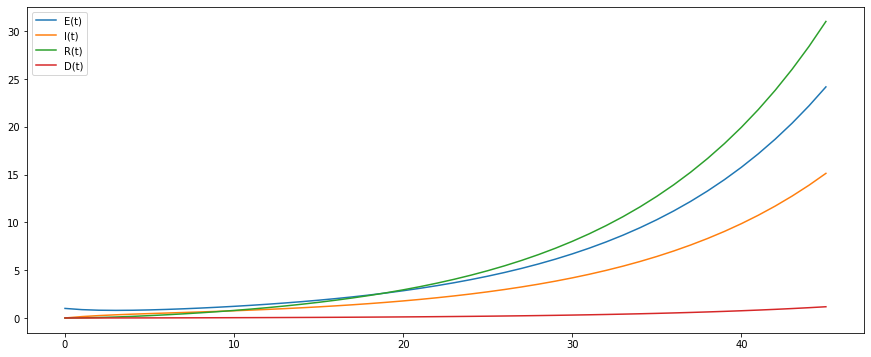

In [37]:
plot_train_example(X_train[13132])